# Projet MOGPL: la balade du robot

### Sportich Benjamin, de Bézenac Emmanuel

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import numpy as np

## GENERATION ALEATOIRE D'INSTANCES

## LECTURE DE FICHIER

In [131]:
def readfile(filename):
    with open(filename) as f:
        M,N = [x for x in f.readline().split()] # lecture de la premiere ligne
        array = []
        i=0
        for line in f: 
            if(i<int(M)): # lecture du bloc
                array.append(np.array([int(x) for x in line.split()]))
                i+=1
            else: #lecture du début, de la fin, ainsi que de la direction
                iStart,jStart,iEnd,jEnd,startDir=[x for x in line.split()]
                break
    return M,N,np.array(array),iStart,jStart,iEnd,jEnd,startDir

Exemple:

In [134]:
m,n,A,iS,jS,iE,jE,sD=readfile('entree.txt')
print m,n,A,iS,jS,iE,jE,sD

9 10 [[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0]] 7 2 2 7 sud


## CREATION & GESTION DU GRAPHE

### Génère le graphe en fonction du tableau d'obstacles

In [135]:
def is_obstacle(i,j,M,N,A):
    #Cas Limites
    if(i==0): #Premiere ligne
        if(j==0): #Premiere case
            return A[0][0]
        if(j==N): #Derniere case
            return A[0][N-1]
        if(j>0 and j<N): #Cases restantes
            return A[0][j] or A[0][j-1]       
    if(i==M): #Dernière ligne
        if(j==0): #Premiere case
            return A[M-1][0]
        if(j==N): #Derniere case
            return A[M-1][N-1]
        if(j>0 and j<N): #Cases restantes
            return A[M-1][j-1] or A[M-1][j] 
    if(j==0): #Premiere colonne 
        if(i>0 and i<M): #Cases restantes
            return A[i][0] or A[i-1][0]       
    if(j==N): #Derniere colonne 
        if(i>0 and i<M): #Cases restantes
            return A[i-1][N-1] or A[i][N-1] 
    #Cas General
    if( i>=1 and j>=1 and i<M and j<N and A[i-1][j-1]==0 and A[i][j-1]==0 and A[i-1][j]==0 ):
        return A[i][j]
    return 1 

def gen_graph(M,N,A):
    G=nx.DiGraph()
    for i in range(M+1):
        for j in range(N+1):
            if(is_obstacle(i,j,M,N,A)==False):              
                #Creation des noeuds - un par direction = 4 par position                
                G.add_node(str(i)+str(j)+'1',direct='nord')
                G.add_node(str(i)+str(j)+'2',direct='est')
                G.add_node(str(i)+str(j)+'3',direct='sud')
                G.add_node(str(i)+str(j)+'4',direct='ouest')

                #Creation des arcs
                #Changement des directions               
                G.add_edge(str(i)+str(j)+'1',str(i)+str(j)+'2',action='D')
                G.add_edge(str(i)+str(j)+'1',str(i)+str(j)+'4',action='G')
                G.add_edge(str(i)+str(j)+'2',str(i)+str(j)+'3',action='D')
                G.add_edge(str(i)+str(j)+'3',str(i)+str(j)+'4',action='D')

                G.add_edge(str(i)+str(j)+'2',str(i)+str(j)+'1',action='G')
                G.add_edge(str(i)+str(j)+'4',str(i)+str(j)+'1',action='D')
                G.add_edge(str(i)+str(j)+'3',str(i)+str(j)+'2',action='G')
                G.add_edge(str(i)+str(j)+'4',str(i)+str(j)+'3',action='G')

                #Deplacement
                #Nord/Haut
                for k in [1,2,3]:
                    if(is_obstacle(i-k,j,M,N,A)==False):
                        G.add_edge(str(i)+str(j)+'1',str(i-k)+str(j)+'1',action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                #Est/Droite
                for k in [1,2,3]:
                    if(is_obstacle(i,j+k,M,N,A)==False):
                        G.add_edge(str(i)+str(j)+'2',str(i)+str(j+k)+'2',action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                
                #Sud/Bas
                for k in [1,2,3]:
                    if(is_obstacle(i+k,j,M,N,A)==False):
                        G.add_edge(str(i)+str(j)+'3',str(i+k)+str(j)+'3',action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                
                #Ouest/Gauche
                for k in [1,2,3]:
                    if(is_obstacle(i,j-k,M,N,A)==False):
                        G.add_edge(str(i)+str(j)+'4',str(i)+str(j-k)+'4',action=('a'+str(k)))
                    else:
                        break #Si il y a un obstacle en i-k on ne creer pas d'arc en i-k-1
                        
    return G

## PARCOURS EN LARGEUR

In [136]:
def BFS(start,end,G):
    dist={}
    for i in G.nodes():
        dist[i]=[np.inf,None] #dist: [distance a start, predecessor] 
    dist[start][0]=0
    q=[start]
    while(q):
        u=q.pop(0)
        for v in G.neighbors(u):
            if(np.isinf(dist[v][0])):
                dist[v][0]=dist[u][0]+1
                dist[v][1]=u
                q.append(v)
    #Backtracking: on retrouve le chemin minimal a partir d'un des 4 sommets de la fin
    path=[]
    prec=end    
    while(prec!=start):
        temp=prec
        prec=dist[prec][1]
        #Si on est deja sur un des 4 sommets de la case de finale on n'ajoute rien au chemin
        if(prec[0:2]!=end[0:2] or temp[0:2]!=end[0:2]):
            #path.append([prec,temp,G[prec][temp]['action']])
            path.append(G[prec][temp]['action'])
    return len(path),path[::-1]

## AFFICHAGE DU GRAPHE

In [142]:
def fixed_pos(G): #Assigne des positions aux noeuds du graphe
    fixed_pos={}
    for n in G.nodes():
        if(n[2]=='1'):
            fixed_pos[n]=(int(n[1])*4+1,int(n[0])*4)
        if(n[2]=='2'):
            fixed_pos[n]=(int(n[1])*4+2,int(n[0])*4+1)
        if(n[2]=='3'):
            fixed_pos[n]=(int(n[1])*4+1,int(n[0])*4+2)
        if(n[2]=='4'):
            fixed_pos[n]=(int(n[1])*4,int(n[0])*4+1)        
    return fixed_pos


def draw_graph(G,pos,ax,sg=None): #Genere l'affichage du graphe
    G_new=G.copy()
    for n in G_new:
        c=Circle(pos[n],radius=0.15,alpha=0.5)
        ax.add_patch(c)
        G_new.node[n]['patch']=c
        x,y=pos[n]
    seen={}
    for (u,v,d) in G_new.edges(data=True):
        n1=G_new.node[u]['patch']
        n2=G_new.node[v]['patch']
        rad=0.2
        if (u,v) in seen:
            rad=seen.get((u,v))
            rad=(rad+np.sign(rad)*0.1)*-1
        alpha=0.5
        color='k'
        e = FancyArrowPatch(n1.center,n2.center,patchA=n1,patchB=n2,
                            arrowstyle='-|>',
                            connectionstyle='arc3,rad=%s'%rad,
                            mutation_scale=10.0,
                            lw=2,
                            alpha=alpha,
                            color=color)
        seen[(u,v)]=rad
        ax.add_patch(e)
    return e

def show_graph(G): # affiche le graphe
    fig=plt.figure(figsize=(10,10))
    ax=plt.subplot(111)
    ax.invert_yaxis()
    draw_graph(G,fixed_pos(G),ax)
    ax.autoscale()
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    #nx.draw_networkx(G,fixed_pos,ax=axe,arrows=True,node_size=400,font_size=10)
    #nx.draw(G,fixed_pos(G),ax=axe)


## MAIN

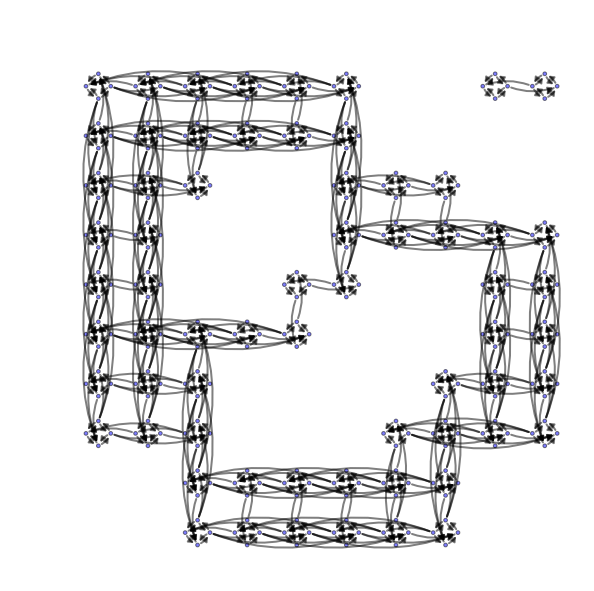

In [143]:
m,n,A,iS,jS,iE,jE,sD=readfile('entree.txt')
if(sD=='nord'):
    sD='1'
if(sD=='est'):
    sD='2'
if(sD=='sud'):
    sD='3'
if(sD=='ouest'):
    sD='4'    
start=iS+jS+sD
end=iE+jE+'1'
G=gen_graph(9,9,A[0:9,0:9]) #A original trop grand pour pouvoir l'afficher
BFS(start,end,G)
show_graph(G3)

## INTERFACE

In [ ]:
M2,N2=2,2
A=np.zeros((M2,N2))
G2=gen_graph(M2,N2,A)
fig=plt.figure(figsize=(10,10))
ax=plt.subplot(111)
ax.invert_yaxis()
ax.autoscale()
nx.draw_networkx(G2,fixed_pos(G2),ax=ax,arrows=True,node_size=400,font_size=10)
#nx.draw(G,fixed_pos(G),ax=ax)
plt.axis('equal')
plt.axis('off')
plt.show()
